Description of the data features:

* **DBNOs** - Number of enemy players knocked.
* **assists** - Number of enemy players this player damaged that were killed by teammates.
* **boosts** - Number of boost items used.
* **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
* **headshotKills** - Number of enemy players killed with headshots.
* **heals** - Number of healing items used.
* **Id** - Player’s Id
* **killPlace** - Ranking in match of number of enemy players killed.
* **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* **killStreaks** - Max number of enemy players killed in a short amount of time.
* **kills** - Number of enemy players killed.
* **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* **matchDuration** - Duration of match in seconds.
* **matchId** - ID to identify match. There are no matches that are in both the training and testing set.
* **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* **revives** - Number of times this player revived teammates.
* **rideDistance** - Total distance traveled in vehicles measured in meters.
* **roadKills** - Number of kills while in a vehicle.
* **swimDistance** - Total distance traveled by swimming measured in meters.
* **teamKills** - Number of times this player killed a teammate.
* **vehicleDestroys** - Number of vehicles destroyed.
* **walkDistance** - Total distance traveled on foot measured in meters.
* **weaponsAcquired** - Number of weapons picked up.
* **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* **groupId** - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* **numGroups** - Number of groups we have data for in the match.
* **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import itertools
import sys
import gc
from IPython import get_ipython

In [2]:
# setup
%matplotlib inline
pd.options.display.max_columns = 50

sns.set_style('darkgrid')
sns.set_palette('bone')

warnings.filterwarnings('ignore')

Util functions

In [3]:
def toTupleList(list1, list2):
    return list(itertools.product(list1, list2))

In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

Load Data

In [6]:
%%time 
train = pd.read_csv('../input/train_V2.csv')
train = reduce_mem_usage(train)

test = pd.read_csv('../input/test_V2.csv')
test = reduce_mem_usage(test)

print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: user 24 s, sys: 5.18 s, total: 29.2 s
Wall time: 29.2 s


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float32
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float32
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float32
roadKills          int8
swimDistance       float32
teamKills          int8
vehicleDestroys    int8
walkDistance       float32
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float32
dtypes: float32(6), int16(5), int8(14), object(4)
memory usage: 339.3+ MB


### NaN values

Initially, we'll check if exists NaN values that could disrupt our evaluation  

In [8]:
nullValues = train[train.isnull().any(axis=1)]
nullValues

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


The dataset has only one NaN register. Let's remove it

In [9]:
print('null values:', len(nullValues))

# let's dropna
train.dropna(inplace=True)

null values: 1


In [10]:
train.shape

(4446965, 29)

### Exploratory Analysis

Let's evaluate information in our dataset. This will help us to better understand our data!

In [11]:
train.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.233815,0.588573,0.0,0.000000,0.000000,0.0000,22.0
boosts,1.106908,1.715794,0.0,0.000000,0.000000,2.0000,33.0
damageDealt,130.633148,169.886963,0.0,0.000000,84.239998,186.0000,6616.0
DBNOs,0.657876,1.145743,0.0,0.000000,0.000000,1.0000,53.0
headshotKills,0.226820,0.602155,0.0,0.000000,0.000000,0.0000,64.0
heals,1.370148,2.679982,0.0,0.000000,0.000000,2.0000,80.0
killPlace,47.599361,27.462931,1.0,24.000000,47.000000,71.0000,101.0
killPoints,505.006156,627.504921,0.0,0.000000,0.000000,1172.0000,2170.0
kills,0.924784,1.558445,0.0,0.000000,0.000000,1.0000,72.0
killStreaks,0.543955,0.710972,0.0,0.000000,0.000000,1.0000,20.0


The dataset has some categorical features, such as **matchType**. We'll deal with them later, but we'll show the  **matchType** values:

In [12]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

**matchType** has **15** possible values.

To visualize the data distribution, we'll create **histograms** of each feature.

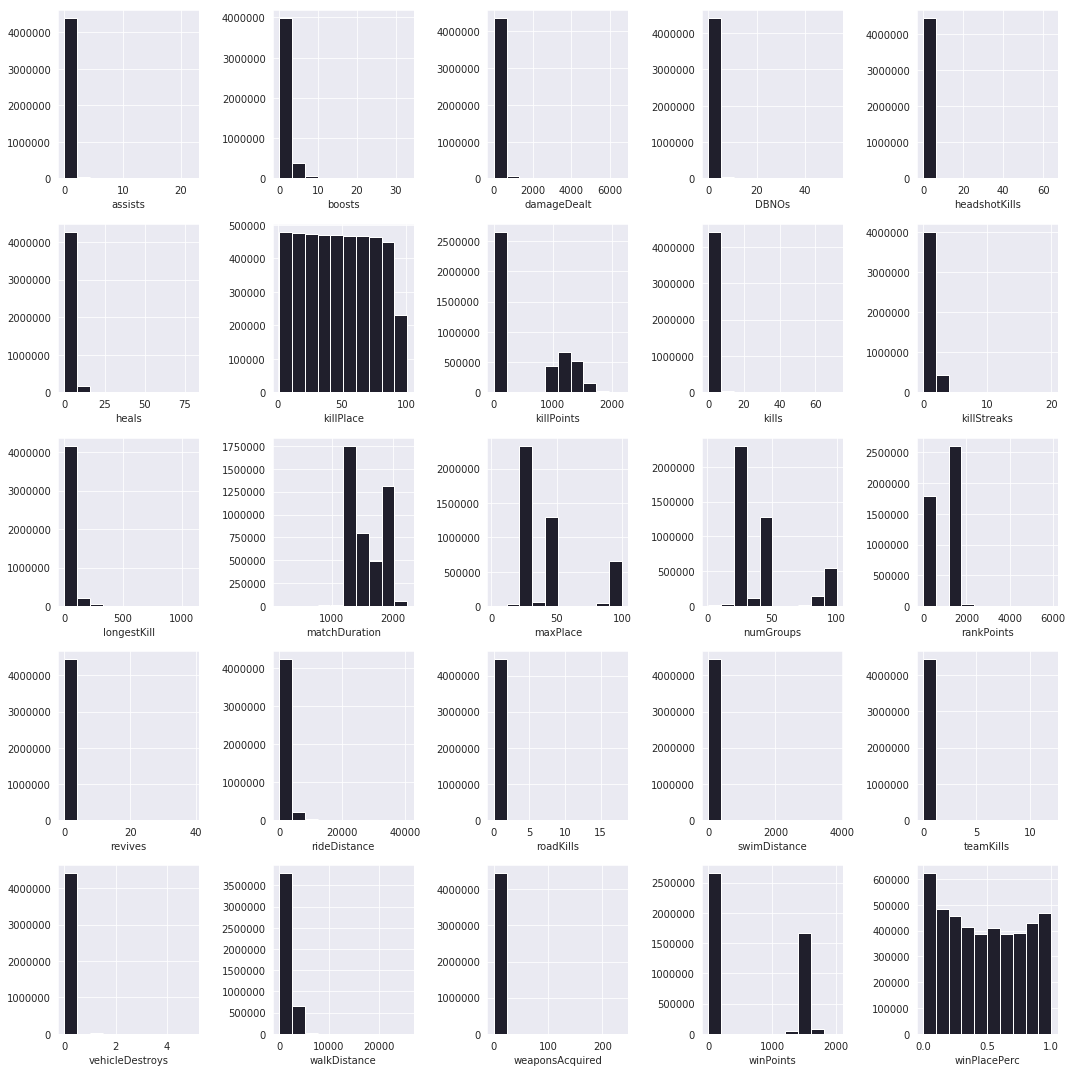

In [13]:
numCols = train.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for c, ax in zip(list(numCols), ax.ravel()):
    ax.set_xlabel(c)
    train[c].hist(bins=10, ax=ax)
    
plt.tight_layout()

According to histograms, the most features has a **skewed distribution**.

Now let's check the correlation between features and the target variable:

In [14]:
corr_matrix = train.corr() # creating correlation matrix
corr_matrix['winPlacePerc'].sort_values(ascending=False)

winPlacePerc       1.000000
walkDistance       0.810888
boosts             0.634234
weaponsAcquired    0.583806
damageDealt        0.440507
heals              0.427857
kills              0.419916
longestKill        0.410154
killStreaks        0.377566
rideDistance       0.342915
assists            0.299441
DBNOs              0.279970
headshotKills      0.277722
revives            0.240881
swimDistance       0.149607
vehicleDestroys    0.073436
numGroups          0.039621
maxPlace           0.037377
roadKills          0.034544
teamKills          0.015943
rankPoints         0.013523
killPoints         0.012908
winPoints          0.007061
matchDuration     -0.005171
killPlace         -0.719069
Name: winPlacePerc, dtype: float64

Previous cell show us that the target variable **winPlacePerc** has a positive correlation with **walkDistance**, **boosts** and **weaponsAcquired**. On the other hand, **winPlacePerc** has a negative correlation with **killPlace**, that is, the higher rank value (1 - 100), the lower its kill rank place, consequently the less chance of victory.

To be more clearly, let's show some graphs:

1) **walkDistance** x **winPlacePerc**

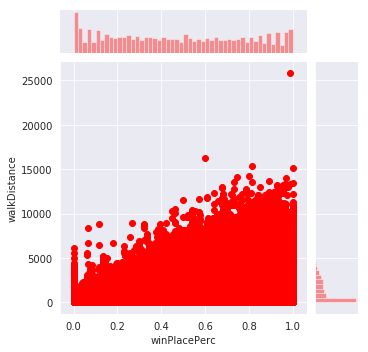

In [15]:
sns.jointplot(x='winPlacePerc', y='walkDistance', data=train, color='red', size=5)
plt.show()

As the Pearson correlation coefficient is between 0.7 and 0.9, **walkDistance** and **winPlacePerc** has a strong correlation, which means that the higher **walkDistance**, the higher **winPlacePerc**.

2) **boosts** x **winPlacePerc** 

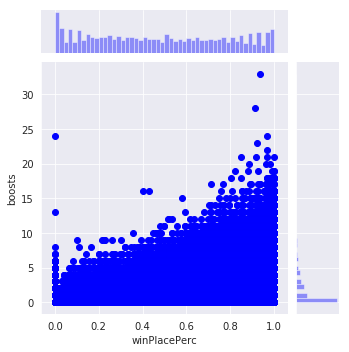

In [16]:
sns.jointplot(x='winPlacePerc', y='boosts', data=train, color='blue', size=5)
plt.show()

As the Pearson correlation coefficient is between 0.5 and 0.7, **boosts** and **winPlacePerc** has a moderate correlation. 

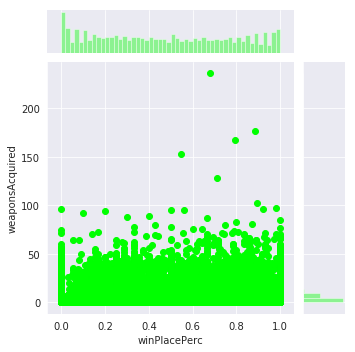

In [17]:
sns.jointplot(x='winPlacePerc', y='weaponsAcquired', data=train, color='lime', size=5)
plt.show()

As the Pearson correlation coefficient is between 0.5 and 0.7, **weaponsAcquired** and **winPlacePerc** has a moderate correlation.

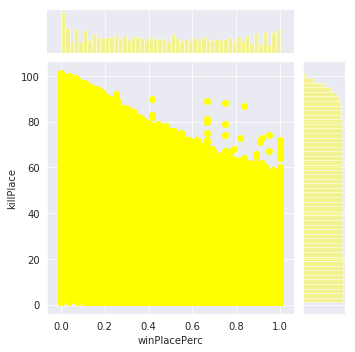

In [18]:
sns.jointplot(x='winPlacePerc', y='killPlace', data=train, color='yellow', size=5)
plt.show()

As the Pearson correlation coefficient is between -0.7 and -0.9, **killPlace** and **winPlacePerc** has a strong negative correlation, which means that the smaller **killPlace** the higher **winPlacePerc**.

Observing the graphs above, we note many outliers, such as a player that acquired **more than 200 weapons**. It's so strange! We'll deal with outliers soon. Before, let's show the heatmap with correlation values between feature pairs:

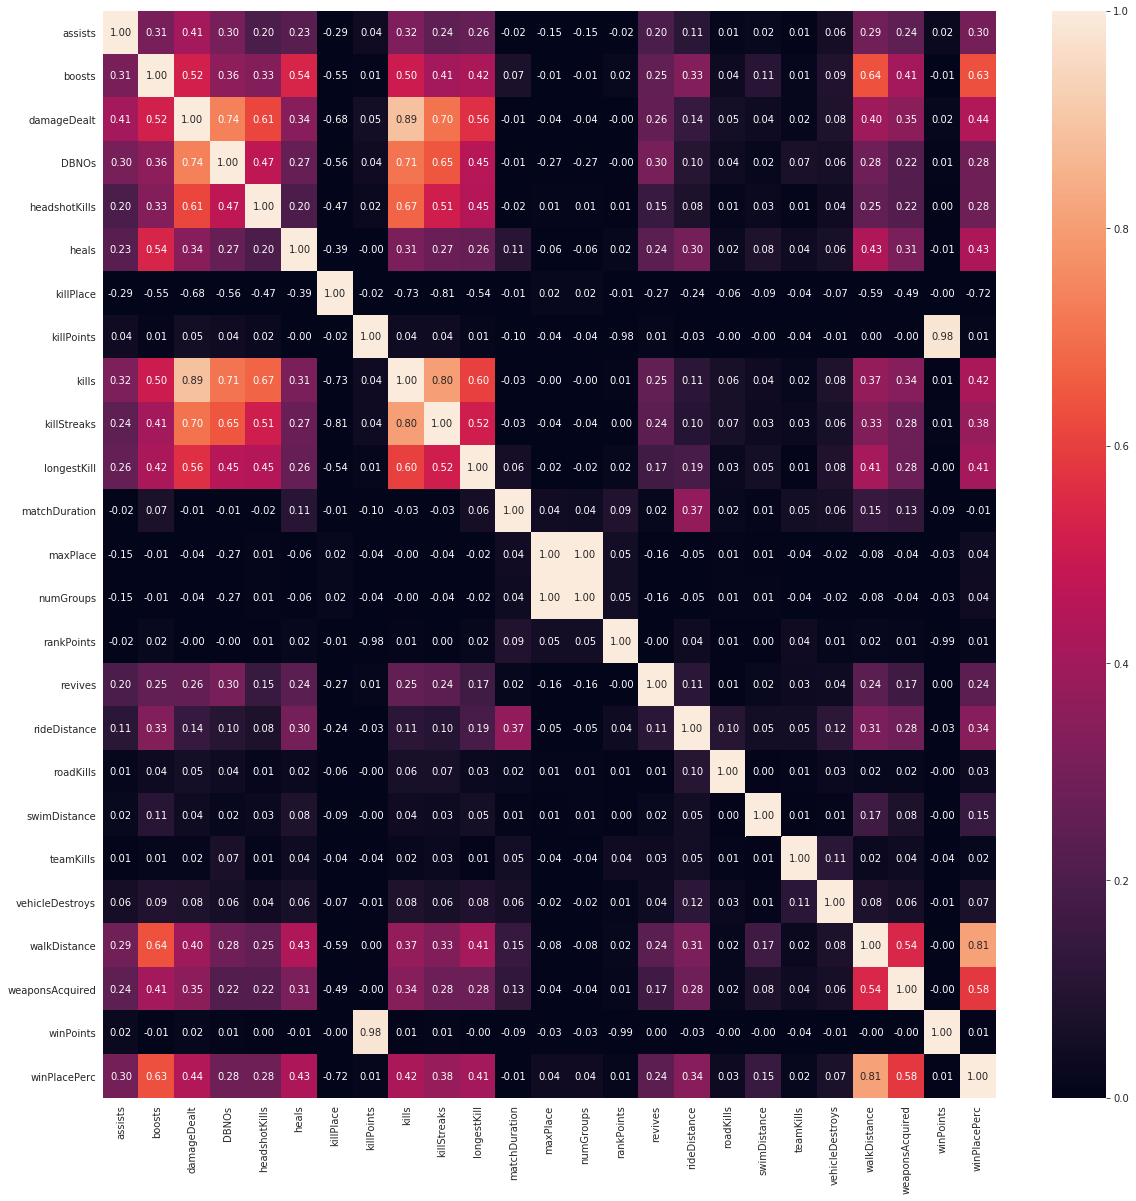

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', vmin=0, vmax=1, ax=ax)
plt.show()

We'll create graphs about target variable and the five features that best correlate with it:

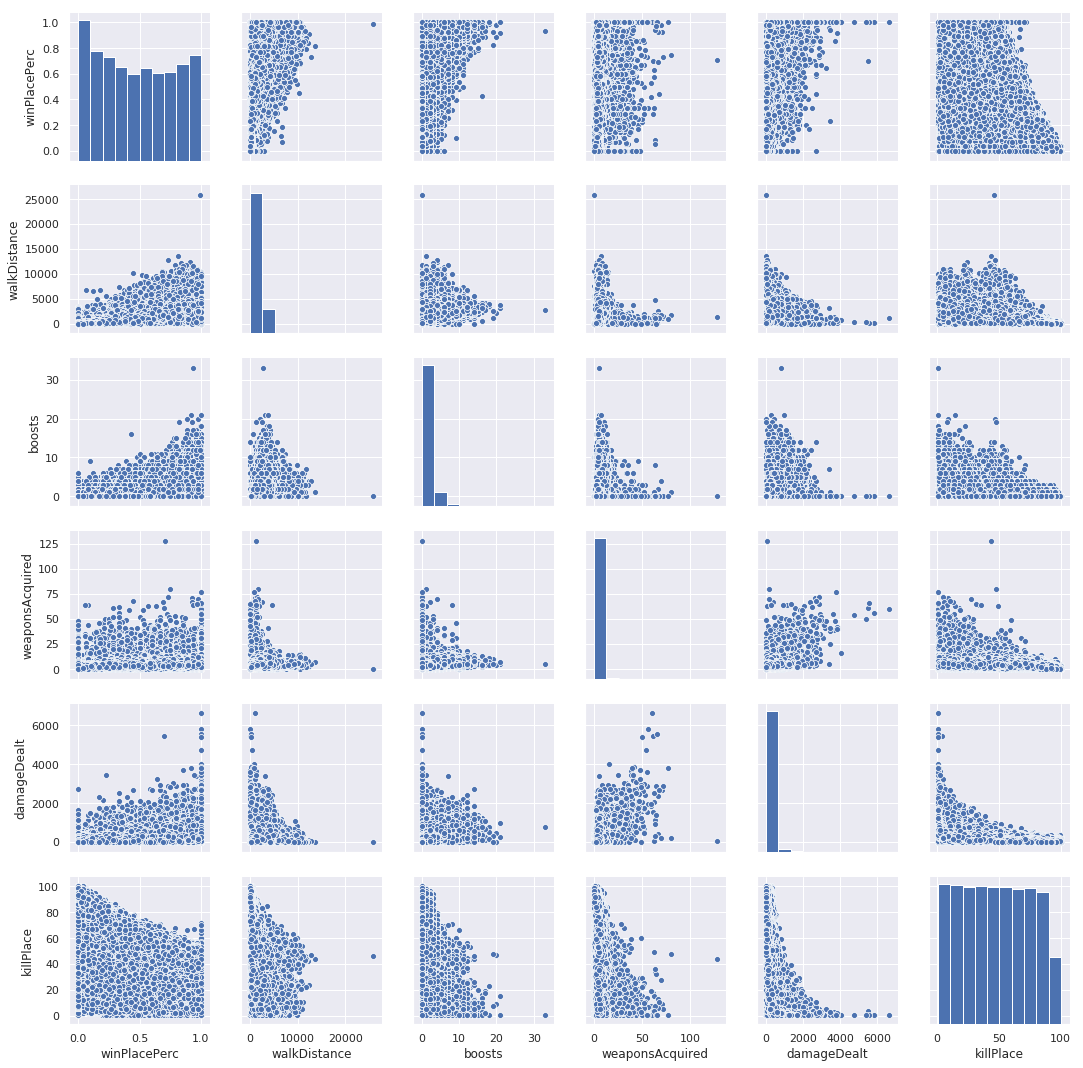

In [20]:
sns.set()
rows=1000000
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(train[cols][:rows], size=2.5)
plt.show()

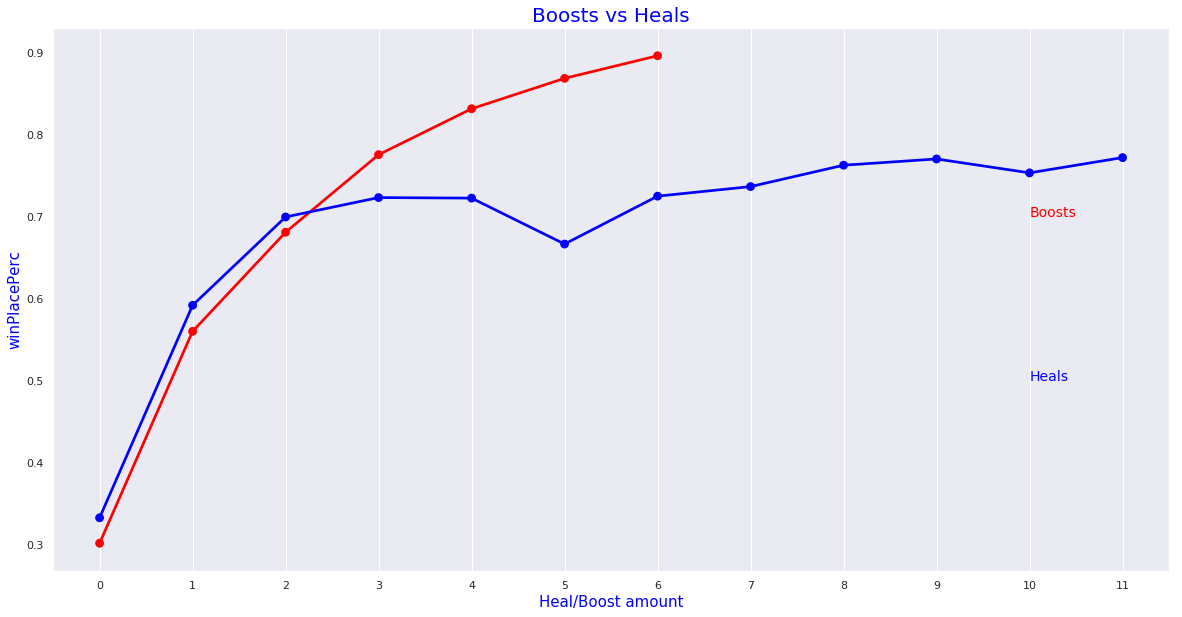

In [21]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(x='boosts', y='winPlacePerc', data=data, color='red', alpha=0.4)
sns.pointplot(x='heals', y='winPlacePerc', data=data, color='blue', alpha=0.4)
plt.text(10, 0.7, 'Boosts', color='red', fontsize=14)
plt.text(10, 0.5, 'Heals', color='blue', fontsize=14)
plt.xlabel('Heal/Boost amount', fontsize=15, color='blue')
plt.ylabel('winPlacePerc', fontsize=15, color='blue')
plt.title('Boosts vs Heals', fontsize=20, color='blue')
plt.grid()
plt.show()

The above chart shows that 99% of players use 6 or fewer boost items and 11 or fewer heal items, besides showing that the chance of victory increases more intensively if they get more than 2 boost items.

In [22]:
for c in ['Id', 'groupId', 'matchId']:
    print(f'{c} different values:', train[c].nunique())

Id different values: 4446965
groupId different values: 2026744
matchId different values: 47964


Transform especial match types and events to standard:

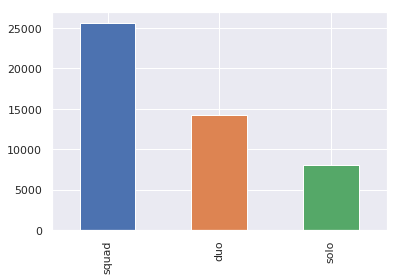

In [23]:
mapper = lambda x: 'solo' if('solo' in x) else 'duo' if('duo' in x) or ('crash' in x) else 'squad'

train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar()
plt.show()

In [24]:
for q in ['maxPlace == numGroups', 'maxPlace != numGroups']:
    print(q, ':', len(train.query(q)))

maxPlace == numGroups : 1241089
maxPlace != numGroups : 3205876


In [25]:
'''matchId: aeb375fc57110c
matchType: squad
numGroups: 25
maxPlace: 26'''
# df = train.query('matchId == "aeb375fc57110c"')
# df.groupby(['matchType', 'groupId']).size()

'matchId: aeb375fc57110c\nmatchType: squad\nnumGroups: 25\nmaxPlace: 26'

In [26]:
cols = ['maxPlace', 'numGroups']
desc = train.groupby('matchType')[cols].describe()[toTupleList(cols, ['min', 'mean', 'max'])]

# groups in match
group = train.groupby(['matchType', 'matchId', 'groupId']).count().groupby(['matchType', 'matchId']).size().to_frame('groups in match')
descGroup = group.groupby('matchType').describe()[toTupleList(['groups in match'], ['min', 'mean', 'max'])]

pd.concat([desc, descGroup], axis=1)

maxPlace                   numGroups                    \
               min       mean    max       min       mean    max   
matchType                                                          
duo            3.0  47.608919   52.0       1.0  45.812482   52.0   
solo           2.0  93.908900  100.0       1.0  91.115282  100.0   
squad          2.0  27.982982   37.0       2.0  27.039389   37.0   

          groups in match                    
                      min       mean    max  
matchType                                    
duo                   1.0  45.348777   52.0  
solo                  1.0  85.679886  100.0  
squad                 2.0  26.834984   37.0

In [27]:
match = train.groupby(['matchId', 'matchType']).size().to_frame('players in match')
group = train.groupby(['matchId', 'matchType', 'groupId']).size().to_frame('players in group')

descMatch = match.groupby('matchType').describe()[toTupleList(['players in match'], ['min', 'mean', 'max'])]
descGroup = group.groupby('matchType').describe()[toTupleList(['players in group'], ['min', 'mean', 'max'])]

pd.concat([descMatch, descGroup], axis=1)

players in match                   players in group                
                       min       mean    max              min      mean   max
matchType                                                                    
duo                    7.0  92.985658  100.0              1.0  2.050456  72.0
solo                   2.0  89.042748  100.0              1.0  1.039249  64.0
squad                  5.0  93.723193  100.0              1.0  3.492575  74.0

Plot players in group

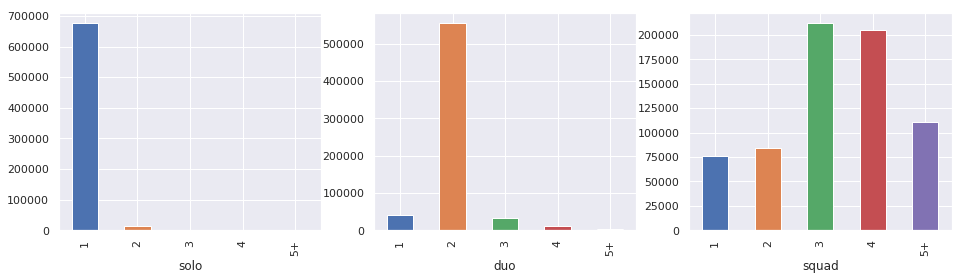

In [28]:
group = train.groupby(['matchId','matchType', 'groupId'])['Id'].count().to_frame('players').reset_index()
group.loc[group['players'] > 4, 'players'] = '5+'
group['players'] = group['players'].astype(str)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for mt, ax in zip(['solo', 'duo', 'squad'], ax.ravel()):
    ax.set_xlabel(mt)
    group[group['matchType'] == mt]['players'].value_counts().sort_index().plot.bar(ax=ax)

Let's do the kills summary in each match

In [29]:
solo = train['matchType'].str.contains('solo')

soloSummary = train.loc[solo].groupby('matchId')['kills'].sum().describe()
teamSummary = train.loc[~solo].groupby('matchId')['kills'].sum().describe()

pd.concat([soloSummary, teamSummary], keys=['solo', 'team'], axis=1).T

,count,mean,std,min,25%,50%,75%,max
solo,8094.0,83.420558,27.592399,0.0,84.0,89.0,92.0,786.0
team,39870.0,86.212039,17.268987,0.0,83.0,87.0,90.0,687.0


Let's do the assists summary

In [30]:
soloSummary = train.loc[solo].groupby('matchId')['assists'].sum().describe()
teamSummary = train.loc[~solo].groupby('matchId')['assists'].sum().describe()

pd.concat([soloSummary, teamSummary], keys=['solo', 'team'], axis=1).T

,count,mean,std,min,25%,50%,75%,max
solo,8094.0,5.541636,6.423455,0.0,3.0,5.0,7.0,219.0
team,39870.0,24.953925,8.904966,0.0,20.0,24.0,29.0,275.0


Relations between rankPoints, killPoints and winPoints

In [31]:
sign = lambda x: 'p<=0' if x <= 0 else 'p>0'
rankWin = pd.crosstab(train['rankPoints'].apply(sign), train['winPoints'].apply(sign), margins=False)
rankKill = pd.crosstab(train['rankPoints'].apply(sign), train['killPoints'].apply(sign), margins=False)

pd.concat([rankWin, rankKill], keys=['winPoints, killPoints'], axis=1)

winPoints, killPoints         
winPoints                   p<=0      p>0
rankPoints                               
p<=0                           0  1791319
p>0                      2655646        0

More about target winPlacePerc

In [32]:
winPlacePerc_1 = train[train['winPlacePerc'] == 1].head()
winPlacePerc_0 = train[train['winPlacePerc'] == 0].head()

pd.concat([winPlacePerc_1, winPlacePerc_0], keys=['winPlacePerc_1', 'winPlacePerc_0'])

Id         groupId         matchId  assists  \
winPlacePerc_1 67   22252be49d4419  37fa7583da2fa2  1ce1cb998f75c7        1   
               107  7970b4ea89e81e  abf9e2780b9f48  04832cfd74ff30        1   
               118  953577684b828a  54ce33c41ef9ff  c5d412db6dbee4        2   
               123  174c758156bcf3  a935604c9bb7aa  edc87c8d445823        1   
               186  eb7a3e9f50eca5  fe3d74f737cd10  92338c2233be1a        0   
winPlacePerc_0 6    95959be0e21ca3  2c485a1ad3d0f1  a8274e903927a2        0   
               29   ac5b57ff39979c  857cc55b2b6001  e019e04dee4f19        0   
               62   eea397f23204bd  19650a810dbdbf  b99cd2f850c233        0   
               74   8b3cdbefd1f408  d25fc68b94f38c  128c05e4e54c63        0   
               103  c4260ce3746cf8  2e3ce1fb9b7812  8fb790bb47a1cc        0   

                    boosts  damageDealt  DBNOs  headshotKills  heals  \
winPlacePerc_1 67        5   378.799988      2              3      6   
               107       1    58.360001      0              0      2   
               118       6    76.110001      0              0     12   
               123       9   626.200012      4              3      2   
               186       5   778.000000      0              3      2   
winPlacePerc_0 6         0     0.000000      0              0      0   
               29        0     0.000000      0              0      0   
               62        0   100.000000      1              0      0   
               74        0     0.000000      0              0      0   
               103       0     0.000000      0              0      0   

                    killPlace  killPoints  kills  killStreaks  longestKill  \
winPlacePerc_1 67           4           0      4            2    61.389999   
               107         38           0      0            0     0.000000   
               118         45           0      0            0     0.000000   
               123          4        1333      6            2    85.739998   
               186          2        1693      8            1   158.899994   
winPlacePerc_0 6           96        1262      0            0     0.000000   
               29          87           0      0            0     0.000000   
               62          41        1272      1            1     3.550000   
               74          91           0      0            0     0.000000   
               103         94           0      0            0     0.000000   

                    matchDuration matchType  maxPlace  numGroups  rankPoints  \
winPlacePerc_1 67            1297     squad        29         28        1431   
               107           1708     squad        26         25        1494   
               118           1388       duo        49         47        1468   
               123           1405     squad        29         28          -1   
               186           1387      solo        98         97          -1   
winPlacePerc_0 6             1316     squad        28         28          -1   
               29            1530       duo        46         44        1534   
               62            1278     squad        27         27          -1   
               74            1376     squad        27         25        1401   
               103           1360     squad        27         27        1489   

                    revives  rideDistance  roadKills  swimDistance  teamKills  \
winPlacePerc_1 67         0    317.700012          0           0.0          0   
               107        0   5134.000000          0           0.0          0   
               118        1      0.000000          0           0.0          0   
               123        0   1045.000000          0           0.0          0   
               186        0      0.000000          0           0.0          0   
winPlacePerc_0 6          0      0.000000          0           0.0          0   
               29         0      0.000000          0          

In [33]:
train[['winPlacePerc']].describe().drop('count').T

,mean,std,min,25%,50%,75%,max
winPlacePerc,0.472814,0.306804,0.0,0.2,0.4583,0.7407,1.0


Match summary

In [34]:
cols = ['kills','teamKills','DBNOs','revives','assists','boosts','heals','damageDealt',
    'walkDistance','rideDistance','swimDistance','weaponsAcquired']

aggs = ['count', 'min', 'mean', 'max']

# solo match
solo = train['matchType'].str.contains('solo')
soloMatch = train.loc[solo].groupby('matchId')[cols].sum()

# team match
teamMatch = train.loc[~solo].groupby('matchId')[cols].sum()

pd.concat([soloMatch.describe().T[aggs], teamMatch.describe().T[aggs]], keys=['solo', 'team'], axis=1)

solo                                         team       \
                  count    min          mean            max    count  min   
kills            8094.0    0.0     83.420558     786.000000  39870.0  0.0   
teamKills        8094.0    0.0      1.022856      15.000000  39870.0  0.0   
DBNOs            8094.0    0.0      0.000000       0.000000  39870.0  0.0   
revives          8094.0    0.0      0.000000       0.000000  39870.0  0.0   
assists          8094.0    0.0      5.541636     219.000000  39870.0  0.0   
boosts           8094.0    0.0     94.372992     182.000000  39870.0  0.0   
heals            8094.0    0.0     90.302570     395.000000  39870.0  0.0   
damageDealt      8094.0  100.0  10610.864258   80991.203125  39870.0  0.0   
walkDistance     8094.0    0.0  85067.085938  156265.718750  39870.0  0.0   
rideDistance     8094.0    0.0  41250.507812  207528.625000  39870.0  0.0   
swimDistance     8094.0    0.0    452.992889    5222.350098  39870.0  0.0   
weaponsAcquired  8094.0    4.0    320.018903    1860.000000  39870.0  0.0   

                                               
                          mean            max  
kills                86.212039     687.000000  
teamKills             2.454552      76.000000  
DBNOs                73.377226     669.000000  
revives              18.365513      81.000000  
assists              24.953925     275.000000  
boosts              104.302132     227.000000  
heals               134.489315     424.000000  
damageDealt       12425.666992   68960.343750  
walkDistance     111468.265625  216150.875000  
rideDistance      59229.429688  370542.187500  
swimDistance        410.993134    9829.960938  
weaponsAcquired     343.311537    1666.000000

### Feature Engineering



* Looking at the data, we realize that they be in different scales. To normalize other features, we must know the distribution of players per match:

In [35]:
# data['numPlayers'] = data.groupby('matchId')['matchId'].transform('count')
# data['numPlayers'].head()

In [36]:
# plt.figure(figsize=(15,10))
# sns.countplot(data.query('numPlayers >= 50')['numPlayers'])
# plt.show()

The above chart show us that the most matches have a number of players close to 100. Now we can use this value to normalize the features. This features can be **kills**, **damageDealt**, **maxPlace** and **matchDuration**, because it all depends on the number of players.

In [37]:
# train_data['killsNorm'] = train_data['kills'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['damageDealt'] = train_data['damageDealt'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['maxPlace'] = train_data['maxPlace'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['matchDuration'] = train_data['matchDuration'] * ((100 - train_data['numPlayers']) / 100 + 1)

#### Detecting cheaters and outliers

As it is an on line game, a good analysis is to check if there are any cheaters:

1) Kills without moving

In [38]:
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))
train.query('killsWithoutMoving == True').shape

(1535, 31)

In [39]:
train.query('killsWithoutMoving == True').head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,squad,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,solo,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,squad,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,True


It's strange because has 1535 registers of players that killed without moving. Some players acquired a lot of weapons, such as player **6d3a61da07b7cb** that caught 22 weapons without moving. Let's remove them!

In [40]:
train.drop(train.query('killsWithoutMoving == True').index, inplace=True)
train.shape

(4445430, 31)

In [41]:
train.drop('killsWithoutMoving', axis=1, inplace=True)

2) Road Kills

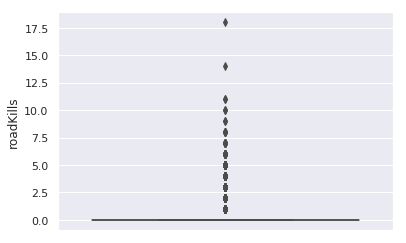

In [42]:
sns.boxplot(y='roadKills', data=train, color='blue')
plt.show()

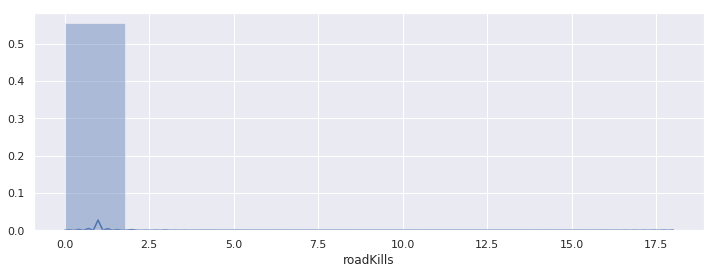

In [43]:
plt.figure(figsize=(12,4))
sns.distplot(train['roadKills'], bins=10)
plt.show()

In [44]:
train['roadKills'].mean()

0.0034972994738416757

It can be seen that the average of the **roadKills** attribute is low, but some players have more than 10. Let's delete them!

In [45]:
train.query('roadKills > 10').shape

(4, 30)

In [46]:
train.query('roadKills > 10').head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181000,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.599976,5,1533,0.4713,4934.600098
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290001,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.399994,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000


The first one (Id = c3e444f7d1289f) has **14 roadkills**, but only **0.005 rideDistance**. Cheater!

In [47]:
train.query('Id == "c3e444f7d1289f"')

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,1282.302002


In [48]:
train.drop(train.query('Id == "c3e444f7d1289f"').index, inplace=True)

In [49]:
train.shape

(4445429, 30)

3) Weapons Acquired

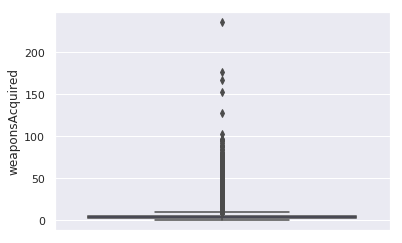

In [50]:
sns.boxplot(y='weaponsAcquired', data=train, color='blue')
plt.show()

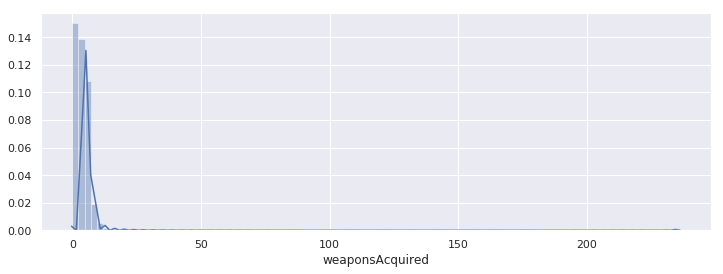

In [51]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [52]:
train['weaponsAcquired'].mean()

3.656768784295059

In [53]:
train.query('weaponsAcquired > 50').shape

(150, 30)

Let's see if there is any player who has acquired more than **50 weapons** but has **totalDistance** below **500m**:

In [54]:
query = '(weaponsAcquired > 50) & (totalDistance < 500)'
train.query(query).shape

(55, 30)

In [55]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
50279,fede4e068062fb,899307b1010c21,a9e84c456cc859,3,0,1691.0,0,3,7,6,0,19,2,48.320000,1795,solo,13,10,1500,0,0.0,0,0.0,0,0,165.300003,52,0,0.6667,165.300003
88852,b45b70a8d261e5,894d0860012ee1,17dea22cefe62a,8,0,1551.0,0,2,6,18,0,14,2,91.580002,1798,duo,15,12,1500,0,0.0,0,0.0,0,0,26.059999,61,0,0.2857,26.059999
100009,6960550b7f37b2,65bcc1e5d4f168,17dea22cefe62a,7,0,2028.0,0,5,6,15,0,18,2,90.260002,1798,duo,15,12,1500,0,0.0,0,0.0,0,0,274.500000,63,0,0.5714,274.500000
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.949997,1798,solo,11,11,1500,0,0.0,0,0.0,0,0,23.709999,61,0,0.7000,23.709999
235791,f52ae56e69bb8f,5b92c879d78e18,634edab75860b3,7,0,1693.0,16,5,2,8,1000,19,3,55.060001,1308,duo,14,13,-1,0,0.0,0,0.0,0,0,34.700001,52,1500,0.8462,34.700001


Cheaters! Removing them:

In [56]:
train.drop(train.query(query).index, inplace=True)

Let's find more:

In [57]:
query = '(weaponsAcquired > 1) & (totalDistance == 0)'
train.query(query).shape

(6496, 30)

In [58]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
846,0df7c355497d77,325464bcf4c846,f3a64f99badeca,0,0,0.000000,0,0,0,5,0,0,0,0.0,1659,solo,19,1,1500,0,0.0,0,0.0,0,0,0.0,6,0,0.0,0.0
1357,72f70c6c074ca9,da042db555b932,f3c5fa51aacb95,0,0,722.799988,0,0,0,5,0,0,0,0.0,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,15,0,0.0,0.0
2640,62f59fc192169d,9151ba6ff83a5a,827e75036742f3,0,0,291.500000,0,0,0,7,0,0,0,0.0,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,2,0,0.0,0.0
3702,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.000000,0,0,0,1,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0,0.0
3826,7ae965d09812d8,db309271857978,36ba8957ba552a,0,0,198.000000,0,0,0,9,0,0,0,0.0,1390,solo,18,1,1500,0,0.0,0,0.0,0,0,0.0,6,0,0.0,0.0


In [59]:
train.drop(train.query(query).index, inplace=True)

In [60]:
query = '(weaponsAcquired > 100)'
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,1279,0,0,0.000000,1901,duo,46,45,-1,0,1880.000000,0,0.000000,0,0,1307.0,128,1577,0.7111,3187.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.599998,1840,squad,29,28,1528,0,2852.000000,0,47.209999,0,0,2400.0,102,0,0.8929,5299.209961
2743408,afcb46681b909f,3715298b7eea9c,4dd4d42772464f,0,4,186.899994,2,0,2,18,1288,2,2,33.430000,1511,duo,45,45,-1,0,1675.000000,0,0.000000,1,0,1643.0,167,1452,0.7955,3318.000000
2749693,940b52bf12805a,4757d102ca4fbf,7ecae2cedc064f,1,3,378.899994,2,0,5,7,1791,3,1,140.500000,1400,squad,27,26,-1,0,303.700012,0,0.000000,0,0,3338.0,177,1711,0.8846,3641.699951
2797867,da68d2812229a8,536975608768ed,fbbdc018f4b771,0,0,0.000000,0,0,0,58,0,0,0,0.000000,1793,solo,98,95,1527,0,0.000000,0,0.000000,0,0,1235.0,153,0,0.5464,1235.000000


The player with Id **da68d2812229a8** acquired **153 weapons**, but only moved by **1235.00m**

In [61]:
train.drop(train.query('Id == "da68d2812229a8"').index, inplace=True)

4) Walk Distance

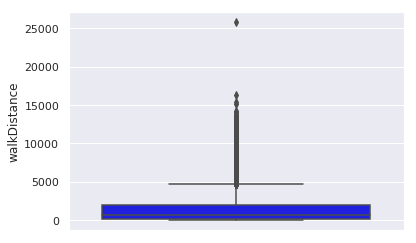

In [62]:
sns.boxplot(y='walkDistance', data=train, color='blue')
plt.show()

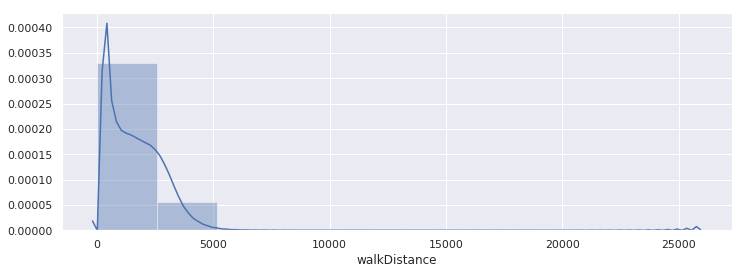

In [63]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [64]:
train['walkDistance'].mean()

1150.608154296875

In [65]:
query = 'walkDistance > 15000'
train.query(query).shape

(4, 30)

In [66]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,0,0,0,0.000000,1889,solo,95,93,1520,0,0.0078,0,381.899994,0,0,25780.0,0,0,0.9894,26161.908203
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,0,0,0,0.000000,1977,squad,26,25,1482,0,0.0401,0,129.399994,0,0,16250.0,3,0,0.6000,16379.440430
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,0,0,0,0.000000,1828,solo,97,95,1651,0,0.0111,0,389.500000,0,0,15370.0,7,0,0.8125,15759.510742
2395009,d6d37216c02c17,56dd8821cacb32,f27850950d5597,0,3,273.299988,0,0,1,11,1300,2,1,136.800003,1932,solo,97,93,-1,0,1575.0000,0,59.049999,0,0,15130.0,3,1583,1.0000,16764.050781


These values are outliers! Let's remove them:

In [67]:
train.drop(train.query(query).index, inplace=True)

In [68]:
train.shape

(4438873, 30)

5) Ride Distance

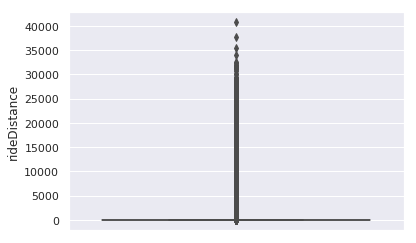

In [69]:
sns.boxplot(y='rideDistance', data=train, color='blue')
plt.show()

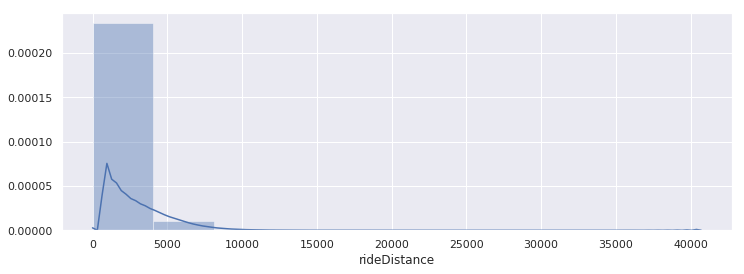

In [70]:
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [71]:
train['rideDistance'].mean()

607.197021484375

In [72]:
query = '(rideDistance > 30000)'
train.query(query).shape

(17, 30)

In [73]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.000000,2007,solo,83,83,-1,0,31960.0,0,0.000000,0,0,402.100006,3,1449,0.8171,32362.099609
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210000,0,0,0,27,1179,0,0,0.000000,1851,solo,51,50,-1,0,33970.0,0,0.000000,0,0,1641.000000,0,1498,0.6800,35611.000000
1214637,470dca70fbef4d,d44161e5d29c1a,c7d52d5aaff270,0,0,127.300003,0,0,8,24,0,1,1,6.300000,1855,solo,95,92,1541,0,31960.0,1,0.000000,0,0,642.000000,1,0,0.9787,32602.000000
1232004,2c5add87b29a8c,1d9d7faa352311,ef2ae297b170f3,0,7,196.899994,0,0,4,24,1517,1,1,85.440002,1862,solo,98,96,-1,0,30030.0,0,53.380001,0,0,1328.000000,2,1565,0.8866,31411.380859
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000000,0,0,10,47,0,0,0,0.000000,1896,solo,95,91,1501,0,31010.0,0,0.000000,1,0,1473.000000,3,0,0.7979,32483.000000


These values are outliers! Let's remove them:

In [74]:
train.drop(train.query(query).index, inplace=True)

Let's see if there are any players who acquired weapons only by ride vehicles

In [75]:
query = '(rideDistance == totalDistance) & (weaponsAcquired >= 1)'
train.query(query).shape

(10956, 30)

In [76]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
711,b9a35e03db6a7f,7b1b2b23d70cad,e1d2ac9fe9bbe1,0,0,0.000000,0,0,0,95,0,0,0,0.0,1408,duo,48,47,1500,0,0.0,0,0.0,0,0,0.0,1,0,0.0000,0.0
1433,0a5036716cd6e0,65d3de7c9396c4,75cbdf89be0139,0,0,85.599998,0,0,0,90,0,0,0,0.0,1884,solo,90,89,1763,0,0.0,0,0.0,0,0,0.0,1,0,0.0000,0.0
1814,269108abb1ba4e,28d3205dd35436,61ec8e0f6bd01d,0,0,0.000000,0,0,0,94,0,0,0,0.0,1292,solo,95,95,1500,0,0.0,0,0.0,0,0,0.0,1,0,0.0106,0.0
4104,bfb4ea17cb8c57,44118a4a6838c1,dea27b499e73c6,0,0,0.000000,0,0,0,94,0,0,0,0.0,1379,solo,95,95,1497,0,0.0,0,0.0,0,0,0.0,1,0,0.0106,0.0
4279,0633b02f422057,ce1f82f7a456f6,719f859dfbbd56,0,0,0.000000,0,0,0,90,0,0,0,0.0,1466,duo,46,44,1436,0,0.0,0,0.0,0,0,0.0,1,0,0.0000,0.0


In the game PUBG, players can not acquire weapons only by ride vehicles. Thus, they are cheaters!

In [77]:
train.drop(train.query(query).index, inplace=True)

6) Swim Distance

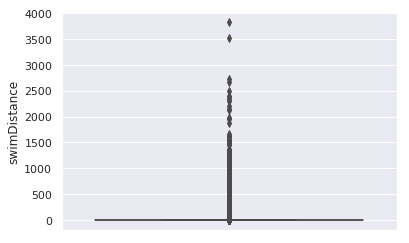

In [78]:
sns.boxplot(y='swimDistance', data=train, color='blue')
plt.show()

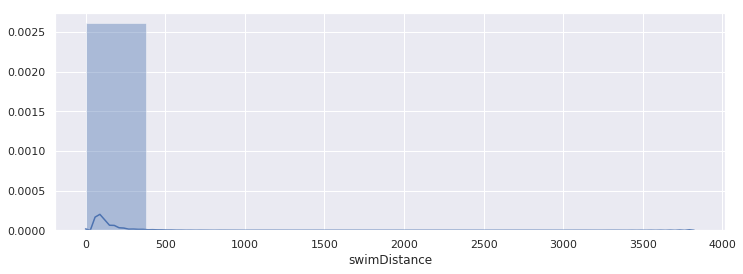

In [79]:
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [80]:
train['swimDistance'].mean()

4.5284247398376465

In [81]:
query = 'swimDistance > 3000'
train.query(query).shape

(2, 30)

In [82]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,0,2,1,48.209999,1021,squad,12,12,1500,0,0.0,0,3823.0,0,0,995.299988,9,0,1.0000,4818.299805
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.590000,0,0,5,48,1097,0,0,0.000000,1379,duo,48,46,0,1,2089.0,0,3514.0,0,0,4296.000000,8,1492,0.8511,9899.000000


These values are outliers! Let's remove them:

In [83]:
train.drop(train.query(query).index, inplace=True)

In [84]:
train.shape

(4427898, 30)

Let's see if there are any players who acquired weapons only by swimming

In [85]:
query = '(swimDistance == totalDistance) & (weaponsAcquired >= 1)'
train.query(query).shape

(1, 30)

In [86]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
4198517,570d3566a3a783,89103856968216,a372e493b3c6e4,0,0,393.600006,0,0,1,40,1000,4,1,74.029999,577,squad,8,8,-1,0,0.0,0,162.100006,3,0,0.0,19,1500,0.0,162.100006


In the game PUBG, players can not acquire weapons in the water. Thus, they are cheaters!

In [87]:
train.drop(train.query(query).index, inplace=True)

In [88]:
train.shape

(4427897, 30)

7) Heals

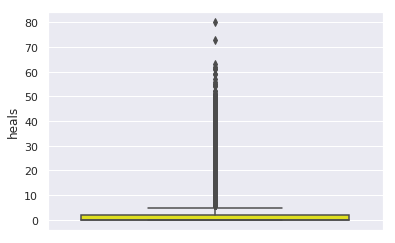

In [89]:
sns.boxplot(y='heals', data=train, color='yellow')
plt.show()

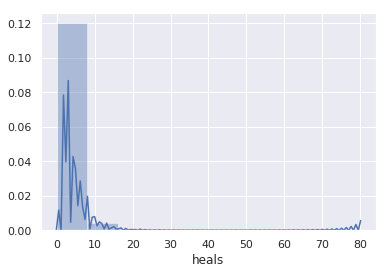

In [90]:
sns.distplot(train['heals'], bins=10)
plt.show()

In [91]:
train['heals'].mean()

1.3751440017687855

In [92]:
query = 'heals > 50'
train.query(query).shape

(19, 30)

In [93]:
train.query(query).head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.000,0,0,52,49,1331,0,0,0.000000,1374,solo,97,96,-1,0,0.000000,0,3.443000,0,0,1340.000000,3,1543,0.8333,1343.442993
700615,512ca0f7c6729b,de2c3988154e5e,03a24daa0f3e65,0,3,0.000,3,0,61,48,0,0,0,0.000000,1876,duo,45,44,1519,3,662.799988,0,0.000000,1,0,963.799988,2,0,0.6364,1626.599976
807030,1b1d77a24be1e1,4b83c72836d02e,109b5a0176fc3e,0,5,0.000,0,0,57,46,0,0,0,0.000000,1766,solo,95,94,1525,0,2583.000000,0,24.969999,0,0,3003.000000,5,0,0.8617,5610.970215
996709,6737eed1cf8dfc,12cc81f7d2eb4d,5f9a59a3ef190d,0,6,1.824,0,0,63,37,1025,0,0,0.000000,1925,solo,80,76,-1,0,3906.000000,0,0.000000,0,0,1752.000000,4,1516,0.8481,5658.000000
1491736,d124f43ee5d74f,dd2f436c57ca92,15154e6d9e5333,0,2,94.500,0,1,55,10,0,2,1,74.169998,1855,squad,28,27,1761,0,1846.000000,0,0.000000,1,0,2117.000000,8,0,0.8148,3963.000000


They are outliers! Let's remove them:

In [94]:
train.drop(train.query(query).index, inplace=True)

In [95]:
train = train.drop('totalDistance', axis=1)

In [96]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [97]:
data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

38504

To be more interesting, we can create new resources through existing resources:

In [98]:
match = data.groupby('matchId')
data['_killsPerc'] = match['kills'].rank(pct=True).values
data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
data['_walkPerc_killsPerc'] = data['_walkDistancePerc'] / data['_killsPerc']

data['_totalDistance'] = data['walkDistance'] + data['rideDistance'] + data['swimDistance']
data['_items'] = data['heals'] + data['boosts']
data['_damageDealtAndWalkDistance'] = data['damageDealt'] + data['walkDistance']
data['_headshotRate'] = data['headshotKills'] / data['kills']
data['_killPlace_maxPlace'] = data['killPlace'] / data['maxPlace']

fillInf(data, 0)

In [99]:
nullCnt = data.isnull().sum()
nullCnt

Id                                   0
groupId                              0
matchId                              0
assists                              0
boosts                               0
damageDealt                          0
DBNOs                                0
headshotKills                        0
heals                                0
killPlace                            0
killPoints                           0
kills                                0
killStreaks                          0
longestKill                          0
matchDuration                        0
matchType                            0
maxPlace                             0
numGroups                            0
rankPoints                           0
revives                              0
rideDistance                         0
roadKills                            0
swimDistance                         0
teamKills                            0
vehicleDestroys                      0
walkDistance             

Drop some features

In [100]:
corr = data.corr()
corr['winPlacePerc'].sort_values(ascending=False)
del corr 
gc.collect()

depCols = ['rideDistance', 'swimDistance', 'heals', 'boosts', 'headshotKills', 'roadKills', 'vehicleDestroys', 'killStreaks', 'DBNOs', 'killPoints', 'rankPoints', 'winPoints', 'matchDuration']
data = data.drop(depCols, axis=1)

Grouping

In [101]:
'''Grouping by match and groups'''
match = data.groupby('matchId')
group = data.groupby(['matchId', 'groupId', 'matchType'])

agg = list(data.columns)
cols_to_exclude = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']

for c in cols_to_exclude:
    agg.remove(c)
    
sum_col = ['kills','killPlace','damageDealt','walkDistance','_items']

matchData = pd.concat([
    match.size().to_frame('m.players'),
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s),
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
], axis=1).reset_index()

matchData = pd.merge(matchData, group[sum_col].sum().rename(columns=lambda s: 'sum.' + s).reset_index())
matchData = reduce_mem_usage(matchData)

Memory usage of dataframe is 407.59 MB --> 288.36 MB (Decreased by 29.3%)


In [102]:
minKills = data.sort_values(['matchId', 'groupId', 'kills', 'killPlace']).groupby(['matchId', 'groupId', 'kills']).first().reset_index().copy()

for n in np.arange(4):
    c = 'kills_' + str(n) + '_Place'
    nKills = (minKills['kills'] == n)
    minKills.loc[nKills, c] = minKills[nKills].groupby(['matchId'])['killPlace'].rank().values
    matchData = pd.merge(matchData, minKills[nKills][['matchId','groupId',c]], how='left')

matchData = reduce_mem_usage(matchData)
del minKills, nKills

Memory usage of dataframe is 377.09 MB --> 332.72 MB (Decreased by 11.8%)


In [103]:
matchData.head()

,matchId,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._items,m.max.kills,m.max.killPlace,m.max.damageDealt,m.max.walkDistance,m.max._items,m.mean.kills,m.mean.killPlace,m.mean.damageDealt,m.mean.walkDistance,m.mean._items,groupId,matchType,sum.kills,sum.killPlace,sum.damageDealt,sum.walkDistance,sum._items,kills_0_Place,kills_1_Place,kills_2_Place,kills_3_Place
0,0000a43bce5eec,95,90.0,4560.0,13539.771484,119082.789062,224.0,7,95,983.700012,3438.0,16,0.947368,48.0,142.523911,1253.503052,2.357895,18b16ec699d8b6,squad,2.0,82.0,219.350006,263.369995,2.0,13.0,NaN,6.0,NaN
1,0000a43bce5eec,95,90.0,4560.0,13539.771484,119082.789062,224.0,7,95,983.700012,3438.0,16,0.947368,48.0,142.523911,1253.503052,2.357895,236ab9e9c081b9,squad,0.0,543.0,287.929993,119.591003,0.0,21.0,NaN,NaN,NaN
2,0000a43bce5eec,95,90.0,4560.0,13539.771484,119082.789062,224.0,7,95,983.700012,3438.0,16,0.947368,48.0,142.523911,1253.503052,2.357895,3a6addfa0df938,squad,0.0,189.0,0.000000,9.636000,0.0,22.0,NaN,NaN,NaN
3,0000a43bce5eec,95,90.0,4560.0,13539.771484,119082.789062,224.0,7,95,983.700012,3438.0,16,0.947368,48.0,142.523911,1253.503052,2.357895,4bf06994bd4c9a,squad,0.0,119.0,23.400000,1118.100098,1.0,12.0,NaN,NaN,NaN
4,0000a43bce5eec,95,90.0,4560.0,13539.771484,119082.789062,224.0,7,95,983.700012,3438.0,16,0.947368,48.0,142.523911,1253.503052,2.357895,4d1bbbc19b9084,squad,6.0,28.0,681.899963,6585.000000,9.0,NaN,1.0,NaN,NaN


In [104]:
'''groups'''
data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg].max().rename(columns=lambda s: 'max.' + s),
    group[agg].min().rename(columns=lambda s: 'min.' + s),
], axis=1).reset_index()

data = reduce_mem_usage(data)

Memory usage of dataframe is 909.45 MB --> 587.81 MB (Decreased by 35.4%)


Aggregate

In [105]:
numCols = data.select_dtypes(include='number').columns.values
numCols = numCols[numCols != 'winPlacePerc']

In [106]:
'''match summary'''
data = pd.merge(data, matchData)
del matchData
gc.collect()

121

In [107]:
sum_col

['kills', 'killPlace', 'damageDealt', 'walkDistance', '_items']

In [108]:
data['enemy.players'] = data['m.players'] - data['players']
 
for c in sum_col:
    data['p.max_msum.' + c] = data['max.' + c] / data['m.sum.' + c]
    data['p.max_mmax.' + c] = data['max.' + c] / data['m.max.' + c]
    data.drop(['m.sum.' + c, 'm.max.' + c], axis=1, inplace=True)
    
fillInf(data, 0)

In [109]:
data.shape

(2907385, 87)

In [110]:
'''match rank'''
match = data.groupby('matchId')
matchRank = match[numCols].rank(pct=True).rename(columns=lambda s: 'rank.' + s)
data = reduce_mem_usage(pd.concat([data, matchRank], axis=1))
rank_col = matchRank.columns
del matchRank
gc.collect()

Memory usage of dataframe is 2179.34 MB --> 1513.89 MB (Decreased by 30.5%)


7

In [111]:
match = data.groupby('matchId')
matchRank = match[rank_col].max().rename(columns=lambda s: 'max.' + s).reset_index()
data = pd.merge(data, matchRank)
for c in numCols:
    data['rank.' + c] = data['rank.' + c] / data['max.rank.' + c]
    data.drop(['max.rank.' + c], axis=1, inplace=True)

del matchRank
gc.collect()

112

In [112]:
'''drop constant columns'''
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print(constant_columns)
data.drop(constant_columns, axis=1, inplace=True)

['rank.maxPlace', 'rank.numGroups']


encode

In [113]:
data['matchType'] = data['matchType'].apply(mapper)

data = pd.concat([data, pd.get_dummies(data['matchType'])], axis=1)
data.drop(['matchType'], axis=1, inplace=True)

data['matchId'] = data['matchId'].apply(lambda x: int(x, 16))
data['groupId'] = data['groupId'].apply(lambda x: int(x, 16))

In [114]:
nullCnt = data.isnull().sum().sort_values()
print(nullCnt[nullCnt > 0])

winPlacePerc    886238
dtype: int64


In [115]:
cols = [col for col in data.columns if col not in ['Id', 'matchId', 'groupId']]
for i, t in data.loc[:, cols].dtypes.iteritems():
    if t == object:
        data[i] = pd.factorize(data[i])[0]

data = reduce_mem_usage(data)
data.head()

Memory usage of dataframe is 1477.85 MB --> 1502.80 MB (Decreased by -1.7%)


,matchId,groupId,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,revives,teamKills,walkDistance,weaponsAcquired,winPlacePerc,_killsPerc,_damageDealtPerc,_walkDistancePerc,_walkPerc_killsPerc,_totalDistance,_items,_damageDealtAndWalkDistance,_headshotRate,_killPlace_maxPlace,max.assists,...,rank.max._items,rank.max._damageDealtAndWalkDistance,rank.max._headshotRate,rank.max._killPlace_maxPlace,rank.min.assists,rank.min.damageDealt,rank.min.killPlace,rank.min.kills,rank.min.longestKill,rank.min.revives,rank.min.teamKills,rank.min.walkDistance,rank.min.weaponsAcquired,rank.min._killsPerc,rank.min._damageDealtPerc,rank.min._walkDistancePerc,rank.min._walkPerc_killsPerc,rank.min._totalDistance,rank.min._items,rank.min._damageDealtAndWalkDistance,rank.min._headshotRate,rank.min._killPlace_maxPlace,duo,solo,squad
0,705378017004,6950488777545910,2,0.0,109.675003,41.0,1.0,6.275,28.0,28.0,0.0,0.0,131.684998,1.000000,0.3333,0.573684,0.534211,0.315789,0.763078,131.684998,1.0,241.360001,0.0,1.464286,0,...,0.303571,0.250000,0.345455,0.678571,0.5,0.553571,0.428571,0.410714,0.410714,1.0,1.0,0.285714,0.288462,0.410714,0.553571,0.285714,0.142857,0.285714,0.625000,0.357143,0.5,0.428571,0.0,0.0,1.0
1,705378017004,9968970908074425,6,0.0,47.988335,90.5,0.0,0.000,28.0,28.0,0.0,0.0,19.931833,0.833333,0.0370,0.321053,0.370175,0.085088,0.265027,19.931833,0.0,67.920166,0.0,3.232143,0,...,0.125000,0.178571,0.345455,0.964286,0.5,0.250000,0.964286,0.410714,0.410714,1.0,1.0,0.053571,0.096154,0.410714,0.250000,0.053571,0.053571,0.053571,0.285714,0.053571,0.5,0.964286,0.0,0.0,1.0
2,705378017004,16443050264754488,2,0.0,0.000000,94.5,0.0,0.000,28.0,28.0,0.0,0.0,4.818000,0.500000,0.0000,0.321053,0.142105,0.028947,0.090164,4.818000,0.0,4.818000,0.0,3.375000,0,...,0.125000,0.035714,0.345455,1.000000,0.5,0.250000,1.000000,0.410714,0.410714,1.0,1.0,0.053571,0.096154,0.410714,0.250000,0.053571,0.053571,0.053571,0.285714,0.053571,0.5,1.000000,0.0,0.0,1.0
3,705378017004,21374959510965402,2,0.0,11.700000,59.5,0.0,0.000,28.0,28.0,0.0,0.0,559.050049,7.000000,0.3704,0.321053,0.250000,0.484211,1.508197,559.050049,0.5,570.750000,0.0,2.125000,0,...,0.303571,0.392857,0.345455,0.642857,0.5,0.250000,0.821429,0.410714,0.410714,1.0,1.0,0.428571,0.500000,0.410714,0.250000,0.428571,0.857143,0.428571,0.285714,0.392857,0.5,0.821429,0.0,0.0,1.0
4,705378017004,21704066427752580,2,1.0,340.949982,14.0,3.0,25.230,28.0,28.0,0.0,0.0,3292.500000,4.000000,1.0000,0.828947,0.805263,0.965789,1.190154,3378.028809,4.5,3633.450195,0.6,0.500000,1,...,0.660714,0.964286,1.000000,0.142857,1.0,0.857143,0.142857,0.857143,0.928571,1.0,1.0,1.000000,1.000000,0.857143,0.857143,1.000000,0.750000,0.964286,0.839286,0.964286,1.0,0.142857,0.0,0.0,1.0


#### Standard Matches

Let's consider only the records about Standard Matches, which are:

* solo
* duo
* squad
* solo-fpp
* duo-fpp
* squad-fpp

In [116]:
# mType = ['solo', 'duo', 'squad', 'solo-fpp', 'duo-fpp', 'squad-fpp']
# idx = train_data[~train_data['matchType'].isin(mType)].index
# train_data.drop(idx, inplace=True)
# train_data['matchType'].value_counts()

In [117]:
# train_data.shape

In [118]:
# match_type_count = train_data['matchType'].value_counts()
# sns.barplot(match_type_count.index, match_type_count.values, alpha=0.9)
# plt.show()

Given that it is a categorical variable, we must turn it into numerical to use it in the model.

In [119]:
# train_data = pd.get_dummies(train_data, columns=['matchType'])
# train_data.head()

### Machine Learning

In [120]:
X_train = data[data['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = data[data['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)
del data
gc.collect()

14

In [121]:
Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId', 'groupId']].copy()
train_matchId = X_train['matchId']

X_train.drop(['matchId', 'groupId'], axis=1, inplace=True)
X_test.drop(['matchId', 'groupId'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(2021147, 141) (886238, 141)


In [122]:
print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

            name        size
0        X_train  1038869662
1         X_test   455526436
2           solo   207794869
3  train_matchId    16169280
4     X_test_grp    14179912
5        Y_train     8084692
6      teamMatch     5781174
7      soloMatch     1173654
8        nullCnt       27105
9       rank_col        9055


In [123]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import minmax_scale
import lightgbm as lgb

params={'learning_rate': 0.1,
        'objective':'mae',
        'metric':'mae',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.7,
        'feature_fraction': 0.7
       }

reg = lgb.LGBMRegressor(**params, n_estimators=10000)
reg.fit(X_train, Y_train)
pred = reg.predict(X_test, num_iteration=reg.best_iteration_)

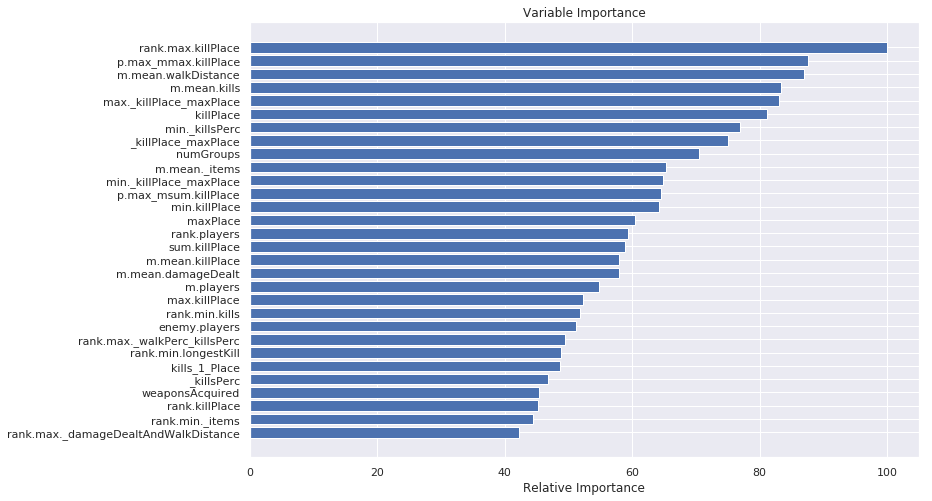

In [124]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [125]:
X_train.columns[np.argsort(-feature_importance)].values

array(['rank.max.killPlace', 'p.max_mmax.killPlace',
       'm.mean.walkDistance', 'm.mean.kills', 'max._killPlace_maxPlace',
       'killPlace', 'min._killsPerc', '_killPlace_maxPlace', 'numGroups',
       'm.mean._items', 'min._killPlace_maxPlace', 'p.max_msum.killPlace',
       'min.killPlace', 'maxPlace', 'rank.players', 'sum.killPlace',
       'm.mean.killPlace', 'm.mean.damageDealt', 'm.players',
       'max.killPlace', 'rank.min.kills', 'enemy.players',
       'rank.max._walkPerc_killsPerc', 'rank.min.longestKill',
       'kills_1_Place', '_killsPerc', 'weaponsAcquired', 'rank.killPlace',
       'rank.min._items', 'rank.max._damageDealtAndWalkDistance',
       'kills_0_Place', 'max._killsPerc', 'rank.max.weaponsAcquired',
       'rank._items', 'rank.max._totalDistance', 'rank._totalDistance',
       'rank.max.walkDistance', 'max._walkPerc_killsPerc',
       'rank.min._headshotRate', 'rank._headshotRate',
       'rank._walkPerc_killsPerc', 'max._damageDealtAndWalkDistance',
     

In [126]:
X_test_grp['_nofit.winPlacePerc'] = pred

group = X_test_grp.groupby(['matchId'])
X_test_grp['winPlacePerc'] = pred
X_test_grp['_rank.winPlacePerc'] = group['winPlacePerc'].rank(method='min')
X_test = pd.concat([X_test, X_test_grp], axis=1)

In [127]:
fullgroup = (X_test['numGroups'] == X_test['maxPlace'])

# full group (201366) --> calculate from rank
subset = X_test.loc[fullgroup]
X_test.loc[fullgroup, 'winPlacePerc'] = (subset['_rank.winPlacePerc'].values - 1) / (subset['maxPlace'].values - 1)

# not full group (684872) --> align with maxPlace
subset = X_test.loc[~fullgroup]
gap = 1.0 / (subset['maxPlace'].values - 1)
new_perc = np.around(subset['winPlacePerc'].values / gap) * gap  # half&up
X_test.loc[~fullgroup, 'winPlacePerc'] = new_perc

X_test['winPlacePerc'] = X_test['winPlacePerc'].clip(lower=0,upper=1)

In [128]:
# edge cases
X_test.loc[X_test['maxPlace'] == 0, 'winPlacePerc'] = 0
X_test.loc[X_test['maxPlace'] == 1, 'winPlacePerc'] = 1  # nothing
X_test.loc[(X_test['maxPlace'] > 1) & (X_test['numGroups'] == 1), 'winPlacePerc'] = 0
X_test['winPlacePerc'].describe()

count    886238.000000
mean          0.499145
std           0.297734
min           0.000000
25%           0.239583
50%           0.500000
75%           0.760870
max           1.000000
Name: winPlacePerc, dtype: float64

In [129]:
test = pd.read_csv('../input/test_V2.csv')
test['matchId'] = test['matchId'].apply(lambda x: int(x,16))
test['groupId'] = test['groupId'].apply(lambda x: int(x,16))

submission = pd.merge(test, X_test[['matchId','groupId','winPlacePerc']])
submission = submission[['Id','winPlacePerc']]
submission.to_csv("submission.csv", index=False)

In [130]:
# from sklearn import linear_model
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_absolute_error, fbeta_score, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import SelectFromModel
# import lightgbm as lgb
# from time import time
# from tqdm import tqdm

In [131]:
# X = train_data.drop(columns=['Id', 'groupId', 'matchId', 'winPlacePerc'])
# y = train_data['winPlacePerc']

#### Feature Selection using Random Forest

In [132]:
# clf = RandomForestRegressor(n_estimators=10,random_state=0, criterion='mse')
# clf.fit(X, y)

# for feature in zip(X.columns, clf.feature_importances_):
#     print(feature)

In [133]:
# sfm = SelectFromModel(clf, threshold=0.004)
# sfm.fit(X, y)

In [134]:
# # Print the names of the most important features
# for feature_list_index in sfm.get_support(indices=True):
#     print(X.columns[feature_list_index])

In [135]:
# X_important = sfm.transform(X)

In [136]:
# def split_train_validation(data, n=100000):
#     return data[n:], data[:n]

In [137]:
# X_train, X_val = split_train_validation(X_important)
# y_train, y_val = split_train_validation(y)

# print('Training samples: {}'.format(len(X_train)))
# print('Validation samples: {}'.format(len(X_val)))

In [138]:
# X_train.shape

### Using LightGBM - Memory efficient usage

In [139]:
# data = lgb.Dataset(X_train, y_train)
# val_data = lgb.Dataset(X_val, y_val)

In [140]:
# param = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 'early_stopping_rounds':200,
#               "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.7,
#                "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
#              }

#### Training LightGBM

In [141]:
# bst = lgb.train(param, data, valid_sets=[val_data], early_stopping_rounds=200, verbose_eval=1000)

#### Save model

In [142]:
# bst.save_model('model.txt', num_iteration=bst.best_iteration)

In [143]:
# print('Training Mean Absolute Error: ', mean_absolute_error(y_train, bst.predict(X_train)))

### Testing some estimators

In [144]:
# def train_predict(learner, sample_size, X_train, y_train, X_val, y_val):
#     '''
#     inputs:
#         - learner: the learning algorithm to be trained and predicted on
#         - sample_size: the size of samples (number) to be drawn from training set
#         - X_train: features training set
#         - y_train: income training set
#         - X_val: features testing set
#         - y_val: income testing set
#     '''
#     results = {}
    
#     start = time()
#     learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
#     end = time()
    
#     results['training_time'] = end - start

#     start = time()
#     predictions_val = learner.predict(X_val)
#     predictions_training = learner.predict(X_train)
#     end = time()
    
#     results['pred_time'] = end - start
    
#     results['mae_training'] = mean_absolute_error(y_train, predictions_training)
#     results['mae_val'] = mean_absolute_error(y_val, predictions_val)
    
#     print('{}: {} samples'.format(learner.__class__.__name__, sample_size))
#     print('Training MAE: {}'.format(results['mae_training']))
#     print('Val MAE: {}'.format(results['mae_val']))
#     print('Training time: {}'.format(results['training_time']))
#     print('Predictions time: {} \n\n'.format(results['pred_time']))

In [145]:
# model_A = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=5)
# model_B = GradientBoostingRegressor(n_estimators=10, max_depth=5, min_samples_leaf=5)
# model_C = BaggingRegressor(n_estimators=10)
# model_D = ExtraTreesRegressor(n_estimators=10, max_depth=5, min_samples_leaf=5)

# samples_100 = len(train_data)
# samples_10 = int(0.1 * samples_100)
# samples_1 = int(0.01 * samples_100)

# results = {}
# for model in [model_A, model_B, model_C, model_D]:
#     for i, samples in enumerate([samples_1, samples_10, samples_100]):
#         train_predict(model, samples, X_train, y_train, X_val, y_val)

In [146]:
# random_state = 42
# model = BaggingRegressor(random_state=random_state)

# parameters = {
#     'n_estimators': [10, 50, 100]
# }

# grid_scorer = make_scorer(mean_absolute_error)
# grid_obj = GridSearchCV(model, parameters, grid_scorer)
# grid_fit = grid_obj.fit(X_train, y_train)

# best_model = grid_fit.best_estimator_

In [147]:
# model = BaggingRegressor(base_estimator=None, bootstrap=True,
#          bootstrap_features=False, max_features=1.0, max_samples=1.0,
#          n_estimators=10, n_jobs=None, oob_score=False, random_state=42,
#          verbose=0, warm_start=False)

# model.fit(X_train, y_train)

In [148]:
# print('Training Mean Absolute Error: ', mean_absolute_error(y_train, model.predict(X_train)))

In [149]:
# print('Validation Mean Absolute Error: ', mean_absolute_error(y_val, model.predict(X_val)))

### Test dataset

In [150]:
# test_data = pd.read_csv('test_V2.csv')
# test_data.head(5)

#### DATA TRANSFORMATIONS

In [151]:
# train_data.drop(train_data[train_data.isnull().values == True].index, axis=0, inplace=True)

# reduce_mem_usage(train_data)

# train_data['totalDistance'] = train_data['walkDistance'] + train_data['rideDistance'] + train_data['swimDistance']
# train_data['damageDealtAndWalkDistance'] = train_data['damageDealt'] + train_data['walkDistance']
# train_data['items'] = train_data['boosts'] + train_data['heals']
# train_data['headshotRate'] = train_data['headshotKills'] / train_data['kills']
# train_data['headshotRate'].fillna(0, inplace=True)
# train_data['revivesHeals'] = train_data['revives'] * train_data['heals']

# train_data['numPlayers'] = train_data.groupby('matchId')['matchId'].transform('count')

# train_data['killsNorm'] = train_data['kills'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['damageDealt'] = train_data['damageDealt'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['maxPlace'] = train_data['maxPlace'] * ((100 - train_data['numPlayers']) / 100 + 1)
# train_data['matchDuration'] = train_data['matchDuration'] * ((100 - train_data['numPlayers']) / 100 + 1)

# train_data['killsWithoutMoving'] = ((train_data['kills'] > 0) & (train_data['totalDistance'] == 0))
# train_data.drop('killsWithoutMoving', axis=1, inplace=True)

# train_data.drop(train_data.query('Id == "c3e444f7d1289f"').index, inplace=True)

# query = '(weaponsAcquired > 50) & (totalDistance < 500)'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = '(weaponsAcquired > 1) & (totalDistance == 0)'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = '(weaponsAcquired > 100)'
# train_data.drop(train_data.query('Id == "da68d2812229a8"').index, inplace=True)

# query = 'walkDistance > 15000'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = '(rideDistance > 30000)'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = '(rideDistance == totalDistance) & (weaponsAcquired >= 1)'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = 'swimDistance > 3000'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = '(swimDistance == totalDistance) & (weaponsAcquired >= 1)'
# train_data.drop(train_data.query(query).index, inplace=True)

# query = 'heals > 50'
# train_data.drop(train_data.query(query).index, inplace=True)

# mType = ['solo', 'duo', 'squad', 'solo-fpp', 'duo-fpp', 'squad-fpp']
# idx = train_data[~train_data['matchType'].isin(mType)].index
# train_data.drop(idx, inplace=True)

# train_data = pd.get_dummies(train_data, columns=['matchType'])